In [ ]:
!nvidia-smi

Sat Sep 18 11:52:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.models as models
from collections import OrderedDict
torch.autograd.set_detect_anomaly(True)
import copy
import datetime
import pytz

import math
import torch.utils.model_zoo as model_zoo
from torch.nn import Parameter
import pdb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
TEST_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/AgeDB/csv/AgeDB_final-with-solve-of-131-corrupted-files-all-classes.csv'
IMAGE_PATH_TEST = '/content/drive/MyDrive/CSE465/datasets/AgeDB/AgeDB-images-with-solved-corrupted-files'

RANDOM_SEED = 42
PATH = '/content/drive/MyDrive/CSE465/Models_and_Logs/All-classes-Full-UTK-CORAL_CDCNpp'
NUM_CLASSES = 101
BATCH_SIZE = 32
GRAYSCALE = False
NUM_WORKERS = 0

In [ ]:
# GPU or CPU
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# Log File
if not os.path.exists(PATH): os.mkdir(PATH)
LOGFILE = os.path.join(PATH, 'evaluation_AgeDB.log')

In [ ]:
header = []
timezone = pytz.timezone('Asia/Dhaka')
header.append(f'\n\n\nLast Run: {datetime.datetime.now(timezone)}')
header.append(f'PyTorch Version: {torch.__version__}')
header.append(f'CUDA device available: {torch.cuda.is_available()}')
header.append(f'Using CUDA device: {DEVICE}')
header.append(f'Random Seed: {RANDOM_SEED}')
header.append(f'NUM WORKERS: {NUM_WORKERS}')
header.append(f'Output Path: {PATH}')
header.append(f'-------------------HyperParameters---------------')
header.append(f'No. of Classes: {NUM_CLASSES}')
header.append(f'Batch size: {BATCH_SIZE}')
header.append(f'Grayscale: {GRAYSCALE}')
header.append(f'\n-------------------EVALUATION RESULTS---------------')

In [ ]:
for entry in header:
  print(entry)




Last Run: 2021-09-18 17:52:09.885954+06:00
PyTorch Version: 1.9.0+cu102
CUDA device available: True
Using CUDA device: cuda
Random Seed: 42
NUM WORKERS: 0
Output Path: /content/drive/MyDrive/CSE465/Models_and_Logs/All-classes-Full-UTK-CORAL_CDCNpp
-------------------HyperParameters---------------
No. of Classes: 101
Batch size: 32
Grayscale: False

-------------------EVALUATION RESULTS---------------


In [ ]:
with open(LOGFILE, 'a') as f:
    for entry in header:
        f.write(f'{entry}\n')
        f.flush()

# Dataset

In [ ]:
df = pd.read_csv(TEST_CSV_PATH, index_col=1)
df

,file,label,label-CE
age,,,
35,0_MariaCallas_35_f.jpg,35,34
40,1_MariaCallas_40_f.jpg,40,39
28,10_MariaCallas_28_f.jpg,28,27
52,100_PaulAnka_52_m.jpg,52,51
1,1000_StephenHawking_1_m.jpg,1,0
...,...,...,...
54,9995_GlennClose_54_f.jpg,54,53
56,9996_GlennClose_56_f.jpg,56,55
58,9997_GlennClose_58_f.jpg,58,57


In [ ]:
class AgeDBDataset(Dataset):
    """Custom Dataset for loading AgeDB face images"""

    def __init__(self, csv_path, img_dir, transform=None, items=None):
        df = pd.read_csv(csv_path)
        df['index'] = range(0, len(df))
        df = df.set_index('index')

        if items:
          df=df[:items]
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['file'].values
        # print(type(self.img_names))
        self.y = df['label'].values
        self.age = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        img = img.convert('RGB')
        
        if self.transform is not None:
          img = self.transform(img)

        label = self.y[index]
        levels = [1]*label + [0]*(NUM_CLASSES - label) #converting labels to levels..so if age is 22, 22 ones and (79-22) zeros, since total class is 101
        levels = torch.tensor(levels, dtype=torch.float32)

        return img, label, levels
        
    def __len__(self):
        return self.y.shape[0]

In [ ]:
custom_transform_test = transforms.Compose([transforms.Resize((256, 256)),
                                        transforms.CenterCrop((224, 224)),
                                        transforms.ToTensor()])

test_dataset = AgeDBDataset(csv_path=TEST_CSV_PATH,
                              img_dir=IMAGE_PATH_TEST,
                              transform=custom_transform_test,
                              items = None
                            )

# Dataset Entity Distribution Analysis

In [ ]:
def dataset_analysis(d):
  counter_label = Counter(np.sort(d.y))
  counter_age = Counter(np.sort(d.age))

  plt.scatter(counter_age.keys(), counter_age.values(), s=10, c='black')
  plt.xlabel('Ages')
  plt.ylabel('Num of images per Age')
  plt.title('Entity Distribution Analysis')
  plt.grid()
  plt.show()
  
  print("label\t\tAge\t\tCount")
  for (label, key, value) in zip(counter_label.keys(), counter_age.keys(), counter_age.values()):
    print(label,'\t\t',key,'\t\t', value)

  print(torch.from_numpy(d.age).bincount())
  print('length of the dataset is: ', len(d))

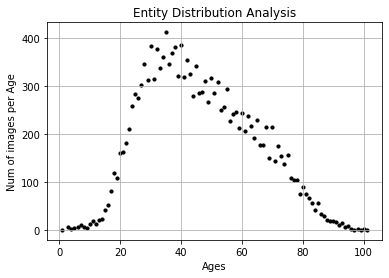

label		Age		Count
1 		 1 		 1
3 		 3 		 8
4 		 4 		 2
5 		 5 		 4
6 		 6 		 8
7 		 7 		 11
8 		 8 		 8
9 		 9 		 6
10 		 10 		 13
11 		 11 		 20
12 		 12 		 14
13 		 13 		 22
14 		 14 		 23
15 		 15 		 43
16 		 16 		 52
17 		 17 		 82
18 		 18 		 120
19 		 19 		 110
20 		 20 		 161
21 		 21 		 163
22 		 22 		 183
23 		 23 		 212
24 		 24 		 259
25 		 25 		 284
26 		 26 		 275
27 		 27 		 304
28 		 28 		 347
29 		 29 		 313
30 		 30 		 385
31 		 31 		 316
32 		 32 		 378
33 		 33 		 338
34 		 34 		 362
35 		 35 		 413
36 		 36 		 347
37 		 37 		 370
38 		 38 		 382
39 		 39 		 321
40 		 40 		 386
41 		 41 		 320
42 		 42 		 356
43 		 43 		 325
44 		 44 		 281
45 		 45 		 342
46 		 46 		 287
47 		 47 		 289
48 		 48 		 311
49 		 49 		 267
50 		 50 		 317
51 		 51 		 287
52 		 52 		 310
53 		 53 		 250
54 		 54 		 258
55 		 55 		 294
56 		 56 		 227
57 		 57 		 243
58 		 58 		 246
59 		 59 		 213
60 		 60 		 245
61 		 61 		 207
62 		 62 		 238
63 		 63 		 218
64 		 64 		 193
65 		 65 		 2

In [ ]:
dataset_analysis(test_dataset)

# Dataset Loader

In [ ]:
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=NUM_WORKERS)

In [ ]:
print(f"No. of Batches for AgeDB: {len(test_loader)}")

No. of Batches for AgeDB: 516


# Model

In [ ]:
class Conv2d_cd(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1,
                 padding=1, dilation=1, groups=1, bias=False, theta=0.7):

        super(Conv2d_cd, self).__init__() 
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.theta = theta

    def forward(self, x):
        out_normal = self.conv(x)

        if math.fabs(self.theta - 0.0) < 1e-8:
            return out_normal 
        else:
            #pdb.set_trace()
            [C_out,C_in, kernel_size,kernel_size] = self.conv.weight.shape
            kernel_diff = self.conv.weight.sum(2).sum(2)
            kernel_diff = kernel_diff[:, :, None, None]
            out_diff = F.conv2d(input=x, weight=kernel_diff, bias=self.conv.bias, stride=self.conv.stride, padding=0, groups=self.conv.groups)

            return out_normal - self.theta * out_diff
        
class SpatialAttention(nn.Module):
    def __init__(self, kernel = 3):
        super(SpatialAttention, self).__init__()


        self.conv1 = nn.Conv2d(2, 1, kernel_size=kernel, padding=kernel//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        
        return self.sigmoid(x)

class CDCN(nn.Module):

    def __init__(self, basic_conv=Conv2d_cd, theta=0.7):   
        super(CDCN, self).__init__()
        
        
        self.conv1 = nn.Sequential(
            basic_conv(3, 64, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(64),
            nn.ReLU(),    
        )
        
        self.Block1 = nn.Sequential(
            basic_conv(64, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),   
            basic_conv(128, 196, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(196),
            nn.ReLU(),  
            basic_conv(196, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),   
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
        )
        
        self.Block2 = nn.Sequential(
            basic_conv(128, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),   
            basic_conv(128, 196, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(196),
            nn.ReLU(),  
            basic_conv(196, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.Block3 = nn.Sequential(
            basic_conv(128, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),   
            basic_conv(128, 196, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(196),
            nn.ReLU(),  
            basic_conv(196, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),   
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.lastconv1 = nn.Sequential(
            basic_conv(128*3, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),    
        )
        
        self.lastconv2 = nn.Sequential(
            basic_conv(128, 64, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(64),
            nn.ReLU(),    
        )
        
        self.lastconv3 = nn.Sequential(
            basic_conv(64, 1, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.ReLU(),    
        )   
        
        self.downsample32x32 = nn.Upsample(size=(32, 32), mode='bilinear')
        
        """newly added start"""
        self.fc_1024_512 = nn.Linear(in_features=1024, out_features=512)
        self.fc_512_1 = nn.Linear(in_features=512, out_features=1, bias=False)
        self.linear_1_bias = nn.Parameter(torch.zeros(NUM_CLASSES).float())
        """newly added end"""

 
    def forward(self, x):	    	# x [3, 256, 256]
        
        x_input = x
        x = self.conv1(x)		   
        
        x_Block1 = self.Block1(x)	    	    	# x [128, 128, 128]
        x_Block1_32x32 = self.downsample32x32(x_Block1)   # x [128, 32, 32]  
        
        x_Block2 = self.Block2(x_Block1)	    # x [128, 64, 64]	  
        x_Block2_32x32 = self.downsample32x32(x_Block2)   # x [128, 32, 32]  
        
        x_Block3 = self.Block3(x_Block2)	    # x [128, 32, 32]  	
        x_Block3_32x32 = self.downsample32x32(x_Block3)   # x [128, 32, 32]  
        
        x_concat = torch.cat((x_Block1_32x32,x_Block2_32x32,x_Block3_32x32), dim=1)    # x [128*3, 32, 32]  
        
        #pdb.set_trace()
        
        x = self.lastconv1(x_concat)    # x [128, 32, 32] 
        x = self.lastconv2(x)    # x [64, 32, 32] 
        x = self.lastconv3(x)    # x [1, 32, 32] 
        
        x = x.squeeze(1)

        """newly added start"""
        x = x.view(x.size(0), -1)
        x = self.fc_1024_512(x)
        x = F.relu(x)
        logits = self.fc_512_1(x)
        logits = logits + self.linear_1_bias
        probas = torch.sigmoid(logits)

        return logits, probas
        """newly added end"""
        
        # return map_x, x_concat, x_Block1, x_Block2, x_Block3, x_input


class CDCNpp(nn.Module):

    def __init__(self, basic_conv=Conv2d_cd, theta=0.7 ):   
        super(CDCNpp, self).__init__()
        
        
        self.conv1 = nn.Sequential(
            basic_conv(3, 64, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(64),
            nn.ReLU(),    
            
        )
        
        self.Block1 = nn.Sequential(
            basic_conv(64, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),  
            
            basic_conv(128, int(128*1.6), kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(int(128*1.6)),
            nn.ReLU(),  
            basic_conv(int(128*1.6), 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(), 
            
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
        )
        
        self.Block2 = nn.Sequential(
            basic_conv(128, int(128*1.2), kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(int(128*1.2)),
            nn.ReLU(),  
            basic_conv(int(128*1.2), 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),  
            basic_conv(128, int(128*1.4), kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(int(128*1.4)),
            nn.ReLU(),  
            basic_conv(int(128*1.4), 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),  
            
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.Block3 = nn.Sequential(
            basic_conv(128, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(), 
            basic_conv(128, int(128*1.2), kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(int(128*1.2)),
            nn.ReLU(),  
            basic_conv(int(128*1.2), 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        # Original
        
        self.lastconv1 = nn.Sequential(
            basic_conv(128*3, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            basic_conv(128, 1, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.ReLU(),    
        )
        
      
        self.sa1 = SpatialAttention(kernel = 7)
        self.sa2 = SpatialAttention(kernel = 5)
        self.sa3 = SpatialAttention(kernel = 3)
        self.downsample32x32 = nn.Upsample(size=(32, 32), mode='bilinear')

        """newly added start"""
        self.fc_1024_512 = nn.Linear(in_features=1024, out_features=512)
        self.fc_512_1 = nn.Linear(in_features=512, out_features=1, bias=False)
        self.linear_1_bias = nn.Parameter(torch.zeros(NUM_CLASSES).float())
        """newly added end"""

 
    def forward(self, x):	    	# x [3, 256, 256]
        
        x_input = x
        x = self.conv1(x)		   
        
        x_Block1 = self.Block1(x)	    	    	
        attention1 = self.sa1(x_Block1)
        x_Block1_SA = attention1 * x_Block1
        x_Block1_32x32 = self.downsample32x32(x_Block1_SA)   
        
        x_Block2 = self.Block2(x_Block1)	    
        attention2 = self.sa2(x_Block2)  
        x_Block2_SA = attention2 * x_Block2
        x_Block2_32x32 = self.downsample32x32(x_Block2_SA)  
        
        x_Block3 = self.Block3(x_Block2)	    
        attention3 = self.sa3(x_Block3)  
        x_Block3_SA = attention3 * x_Block3	
        x_Block3_32x32 = self.downsample32x32(x_Block3_SA)   
        
        x_concat = torch.cat((x_Block1_32x32,x_Block2_32x32,x_Block3_32x32), dim=1)    
        
        #pdb.set_trace()
        
        x = self.lastconv1(x_concat)
        x = x.squeeze(1)

        """newly added start"""
        x = x.view(x.size(0), -1)
        x = self.fc_1024_512(x)
        x = F.relu(x)
        logits = self.fc_512_1(x)
        logits = logits + self.linear_1_bias
        probas = torch.sigmoid(logits)

        return logits, probas
        """newly added end"""
        
        # return map_x, x_concat, attention1, attention2, attention3, x_input

# Initialize Model, and Optimizer

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
# model = CDCN()
model = CDCNpp()

model.to(DEVICE)
print(model)

CDCNpp(
  (conv1): Sequential(
    (0): Conv2d_cd(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (Block1): Sequential(
    (0): Conv2d_cd(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d_cd(
      (conv): Conv2d(128, 204, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (4): BatchNorm2d(204, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d_cd(
      (conv): Conv2d(204, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=3, stride=2

# Evaluation

In [ ]:
def calculate_correct_preds(probas, targets):
  return torch.sum(torch.max(probas, dim = 1)[1] == targets)

In [ ]:
def compute_acc(total_num_correct_preds, num_examples):
  return format((total_num_correct_preds/num_examples) * 100.0, '.3f')

In [ ]:
def compute_mae_and_mse(model, data_loader, device):
  mae, mse, num_examples, total_num_correct_preds = 0., 0., 0, 0
  for i, (features, targets, levels) in enumerate(tqdm(data_loader)):
          
    targets, features = targets.to(device), features.to(device)
    logits, probas = model(features)
    predict_levels = probas > 0.5

    predicted_labels = torch.sum(predict_levels, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)
    total_num_correct_preds += num_correct_preds
    num_examples += targets.size(0)

    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

  print(f'total_num_correct_preds: {total_num_correct_preds}')
  acc = compute_acc(total_num_correct_preds, num_examples)
  mae = format(mae.float()/num_examples, '.3f')
  mse = format(torch.sqrt(mse.float()/num_examples), '.3f')      

  return mae, mse, acc

# Testing on AgeDB

In [ ]:
lists = [i for i in range(46,65)] # number epochs to evaluate
result_dict = {}

start_time = time.time()
test_mae = test_mse = test_acc = 0.0
for i in tqdm(lists):
  model_name = f'Epoch_{i}_model.pt'
  model.load_state_dict(torch.load(os.path.join(PATH, model_name)))
  model.to(DEVICE)
  model.eval()

  with torch.set_grad_enabled(False):
    str0 = f'---------------{model_name}-----------------\n'
    print(str0)
    test_mae, test_mse, test_acc = compute_mae_and_mse(model, test_loader, device=DEVICE)
    
    result_dict[model_name] = test_mae    
    str1 = f'MAE/RMSE/ACC: | AGEDB-Test: {test_mae}/{test_mse}/{test_acc}%\n'
    str = str0+str1
    print(str1)
    with open(LOGFILE, 'a') as f: f.write(f'{str}\n')
    
time_elapsed = format((time.time() - start_time)/60, ".3f")
str = f'Time elapsed: {time_elapsed}mins\n'
print(str)
with open(LOGFILE, 'a') as f: f.write(f'{str}')

In [ ]:
result_list = sorted(result_dict.items(), key=lambda item:float(item[1]))

In [ ]:
with open(LOGFILE, 'a') as f:
    f.write(f'\n\n----Result in Sorted Order----\n\n')
    for item in result_list:
        string = f'{item[0]} {item[1]}\n'
        f.write(string)
        print(string)
        f.flush()